# ML for science - Unfold
## Baudoin von Sury - Pierre Vuillecard - Hugo Birch

## This notebook present the different predictions of CP using Neural Networks maching learning method.

We used the sklearn python librairy (https://keras.io) to perform different regression on our data.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.activations import elu
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import probplot

from neural_networks import *
from helpers import *

np.random.seed(123)

In [5]:
# Definition of the path of the data
path = os.getcwd()
path = path + '/ml_data/complete/complete/'

In [6]:
# Load the data (CL and kinematic alphas for the N_EXP experiments)
N_EXP = 4100
CP = load_data(path,N_EXP, cl = False)

# Shuffle the data
random_permuted_indices = np.random.permutation(N_EXP)
CP = CP[random_permuted_indices,:,:]

# Part 1 : Prediction of average CP from kinematic alpha
The aim of this part is to find the best neural network to predict CP from kinematic alphas. We used simple neural network structure from keras library and tunned it with the following techniques :
- Adding hidden layers.
- Playing with the hidden layers sizes.
- Trying different activation functions.
- Increasing the number of epoch.
- Choosing a wise early stopping criteria.
We analyse the performance of each different models through the mse and a probability plot.

In [7]:
def model_training(model,X_train,X_test,Y_train,Y_test, patience_ = 50 , plot=True ):
    """Train the different models and return the MSE values"""
    early_stop = EarlyStopping(monitor ="val_loss", patience = patience_ , verbose = 1)
    history = model.fit(X_train, Y_train, validation_split=0.2, epochs=2000 ,callbacks=[early_stop] , verbose=0)
    train_mse = model.evaluate(X_train, Y_train, verbose=0)
    test_mse = model.evaluate(X_test, Y_test, verbose=0)
    print('MSE Train: %.3f | MSE Test: %.3f' % (train_mse, test_mse))
    if plot :
        # plot loss during training
        plt.title('Loss / Mean Squared Error')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    return train_mse,test_mse

## Base Line model
We first start by creating a base-line model in order to have a reference.

In [8]:
num_train = int(0.8*N_EXP)
# Split the data in train and test set
X_train = CP[:num_train,0,:]
X_test = CP[num_train:,0,:]
Y_train = CP[:num_train,1,:]
Y_test = CP[num_train:,1,:]

In [9]:
def build_model_base_line(summary = True):
    """Create the architecture of the base line model"""
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [10]:
# Build and print the summary of the base-line model
model_base_line = build_model_base_line()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
Total params: 40,200
Trainable params: 40,200
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00254: early stopping
MSE Train: 14.926 | MSE Test: 16.744


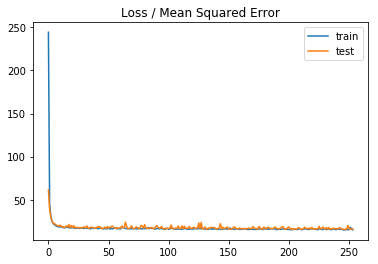

In [11]:
mse_train, mse_test = model_training(model_base_line,X_train,X_test,Y_train,Y_test, plot=True)

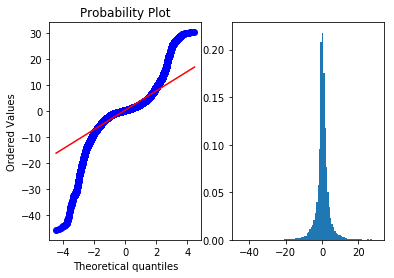

In [12]:
plot_stat(model_base_line,X_test,Y_test)

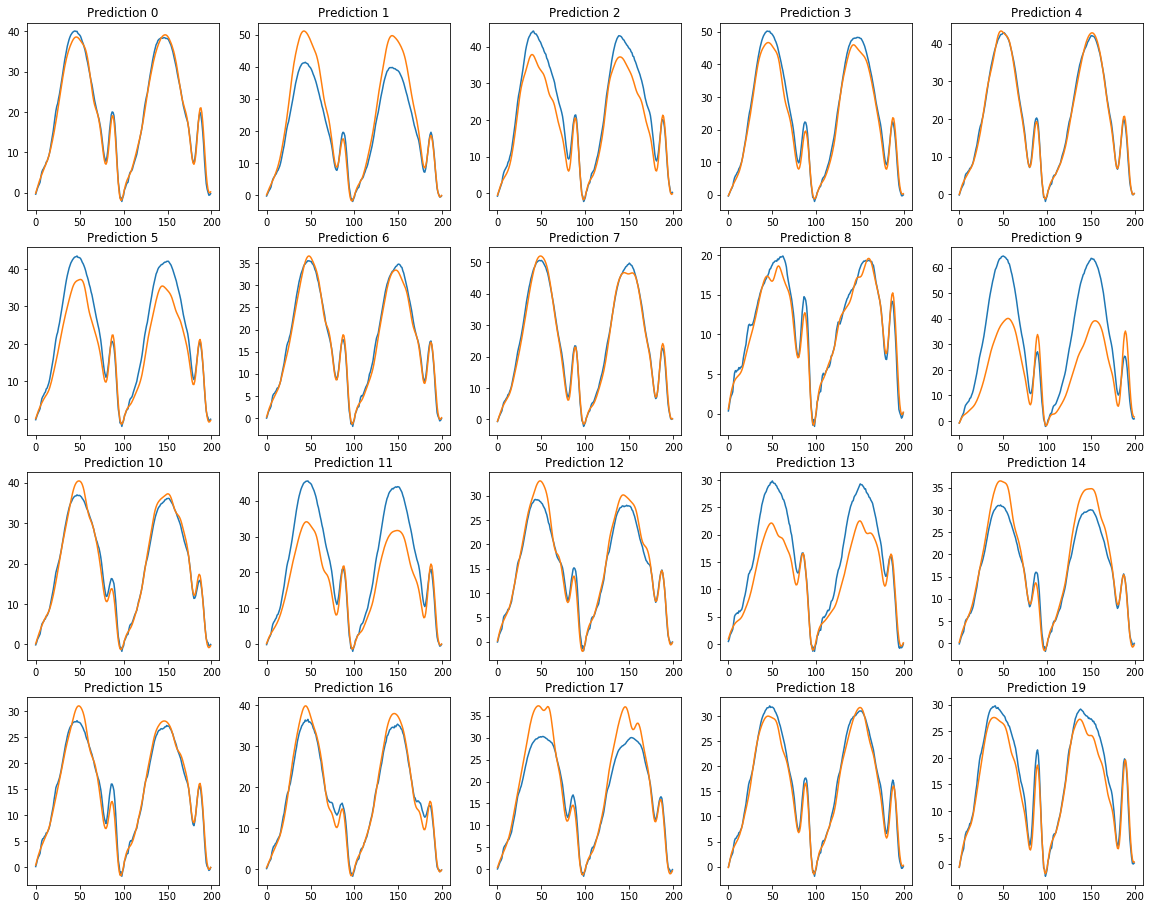

In [13]:
# Plots some examples of the predictions on the dataset
plot_prediction(model_base_line,X_test,Y_test)

###### Comments : The data seems to fit , but there is large biais in the result.
###### Next step : Add an hidden layer

In [14]:
def build_model_1(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [15]:
model_1 = build_model_1()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
Total params: 80,400
Trainable params: 80,400
Non-trainable params: 0
_________________________________________________________________
None


Epoch 01332: early stopping
MSE Train: 3.966 | MSE Test: 4.254


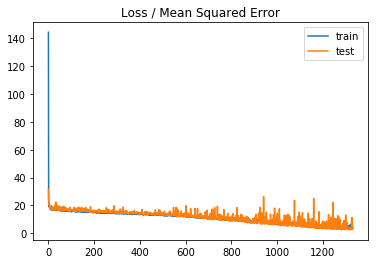

(3.9664175777900508, 4.254296581919601)

In [16]:
model_training(model_1,X_train,X_test,Y_train,Y_test, plot=True)

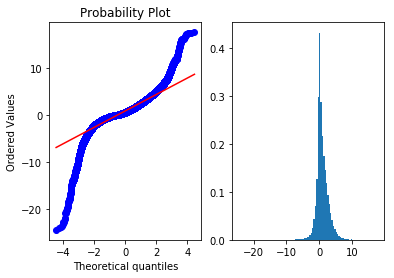

In [17]:
plot_stat(model_1,X_test,Y_test)

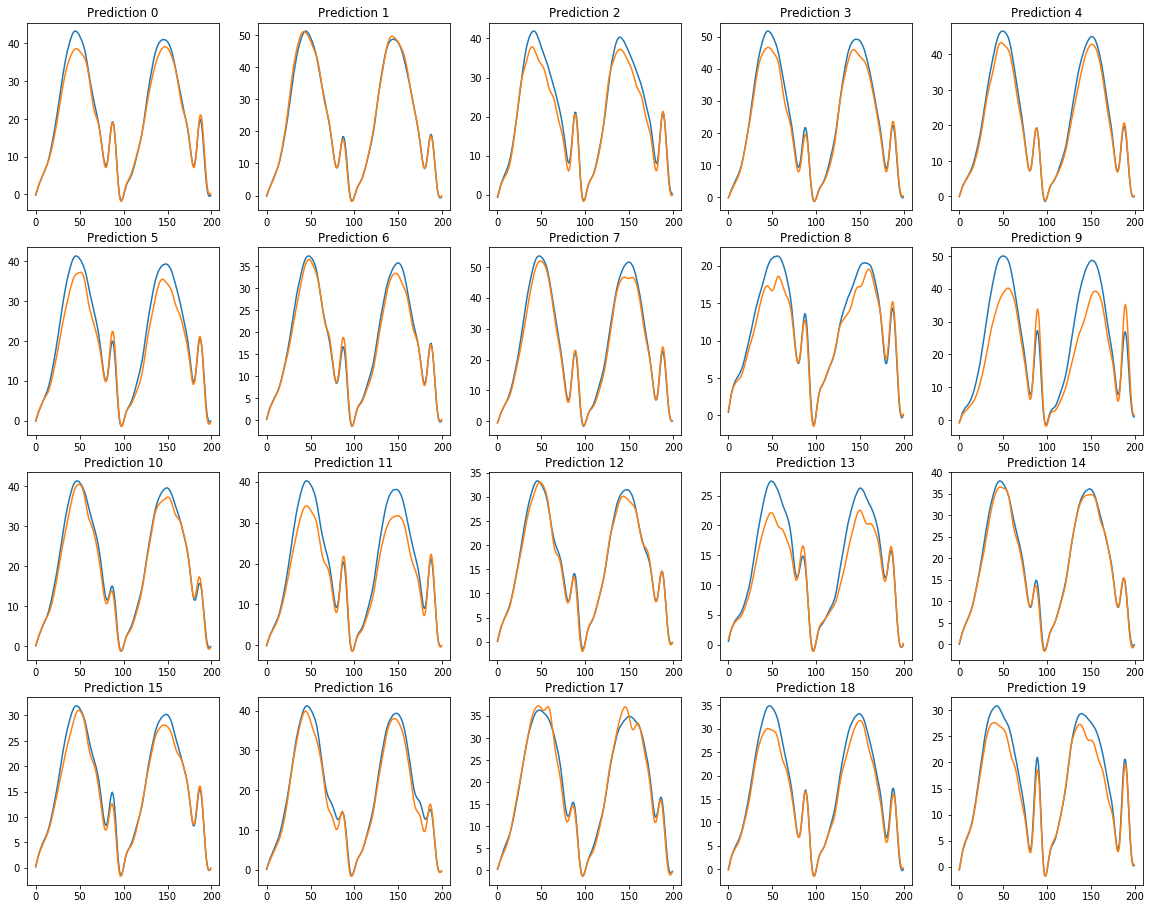

In [18]:
plot_prediction(model_1,X_test,Y_test)

###### Comments : We improved the MSE with this architecture and we see that it is fitting better
### We now add 2 hidden layers and use the elu activation function with an alpha = 2.5

In [19]:
def build_model_2(summary = True):
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    model.add(Activation(lambda x: elu(x, alpha=2.5)))
    model.add(Dense(200))
    model.add(Activation(lambda x: elu(x, alpha=2.5)))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [20]:
model_2 = build_model_2()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00344: early stopping
MSE Train: 0.721 | MSE Test: 0.830


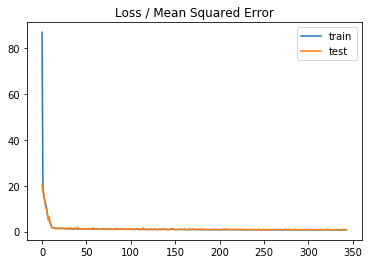

(0.7211873827911005, 0.8302483762182841)

In [21]:
model_training(model_2,X_train,X_test,Y_train,Y_test,plot=True )

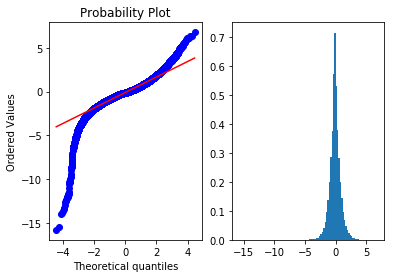

In [22]:
plot_stat(model_2,X_test,Y_test)

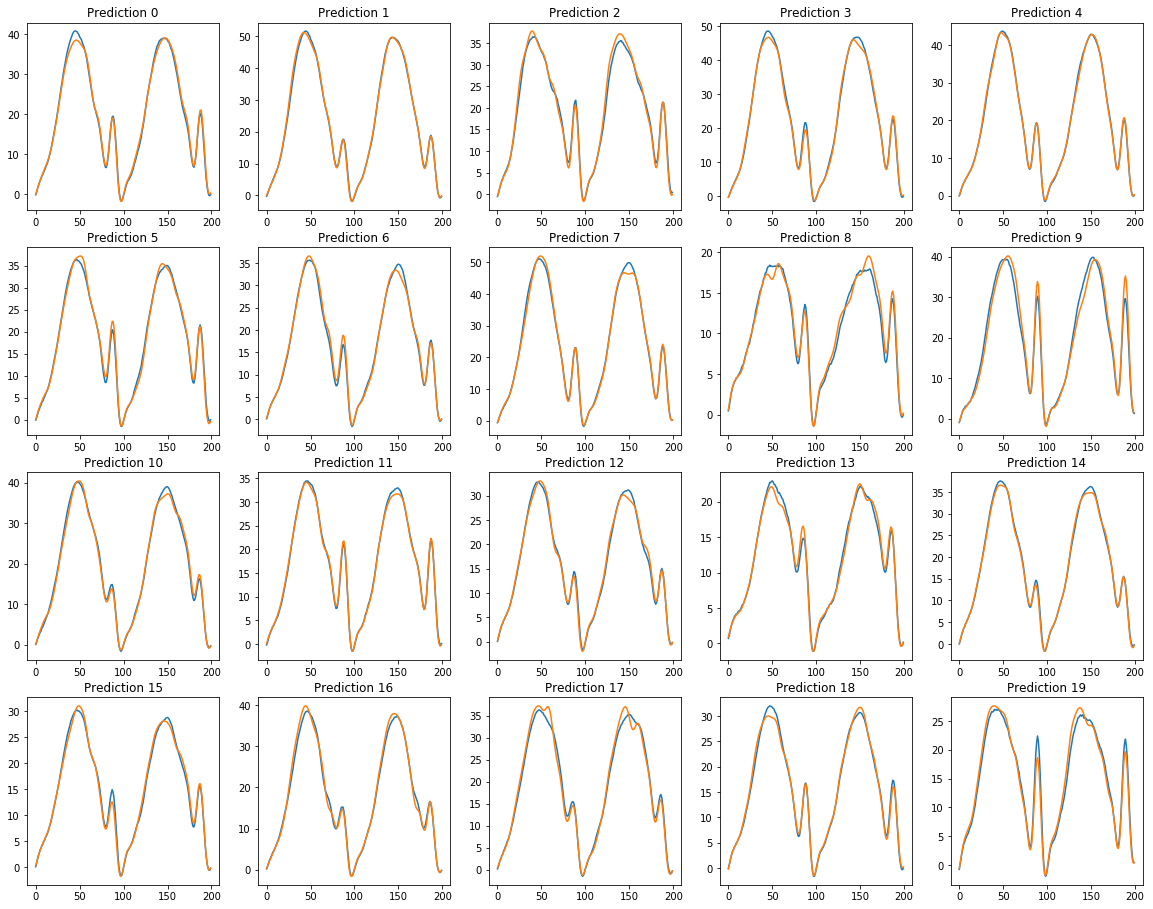

In [23]:
plot_prediction(model_2,X_test,Y_test)

###### Comments :  this model much better and fit the data pretty well. The QQplot seems that the error distribution has heavy tail.
### We now try to use different activation functions

In [24]:
def build_model_3(summary = True):

    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,),activation ='relu'))
    model.add(Dense(200,activation ='elu'))
    model.add(Dense(200,activation = 'linear'))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mse',optimizer='adam')
    return model

In [25]:
model_3 = build_model_3()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00295: early stopping
MSE Train: 0.781 | MSE Test: 0.928


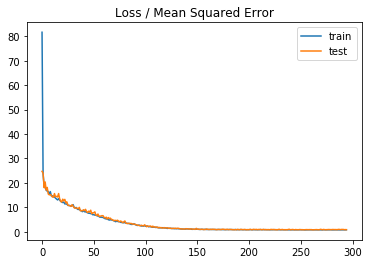

(0.7813880946578049, 0.9278606060074597)

In [26]:
model_training(model_3,X_train,X_test,Y_train,Y_test,plot= True)

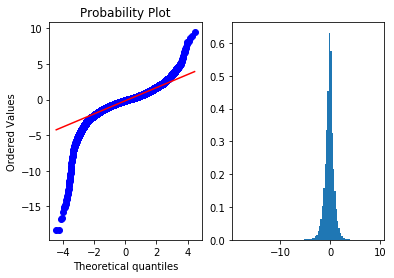

In [27]:
plot_stat(model_3,X_test,Y_test)

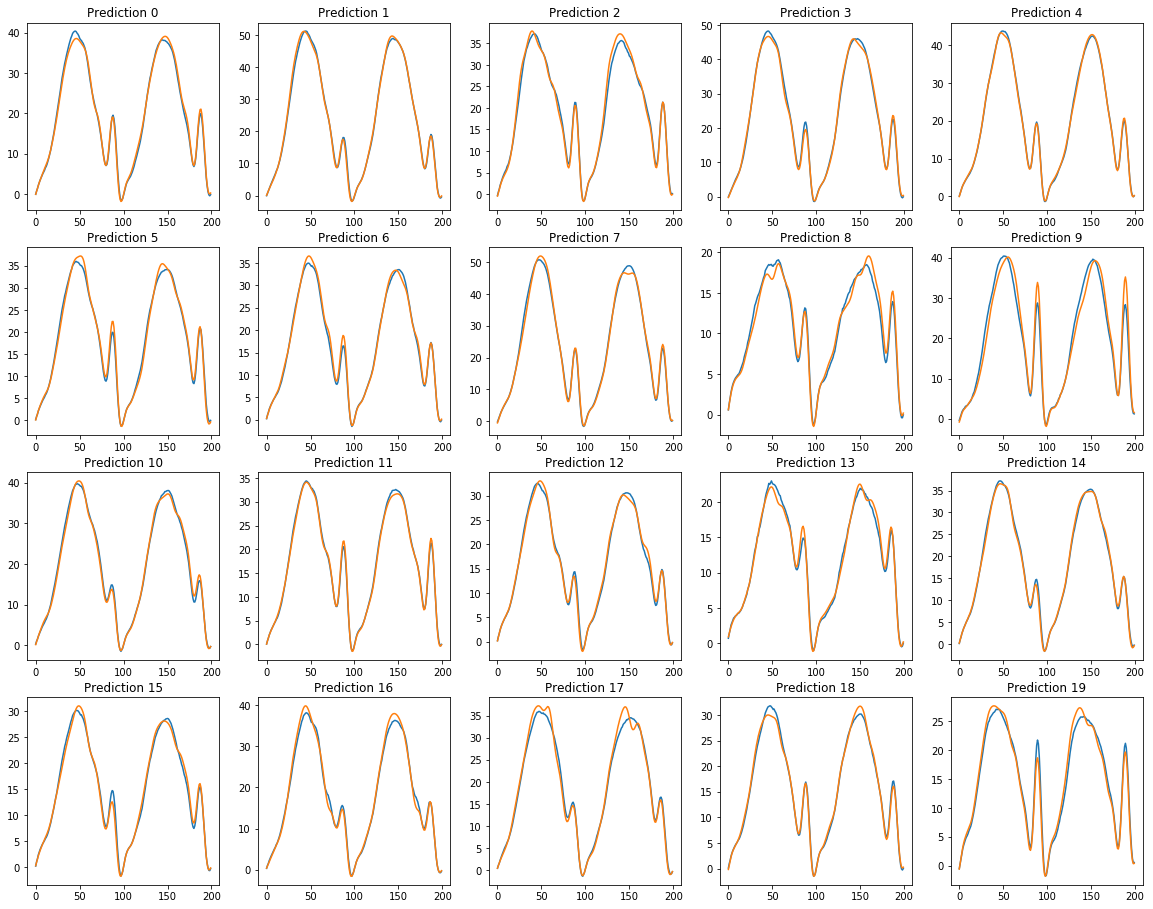

In [28]:
plot_prediction(model_3,X_test,Y_test)

###### Comments : This configuration is not as good as the previous one
### We now add try different other activation functions

In [29]:
def build_model_4(summary = True):
    model = Sequential()
    model.add(Dense(330 ,input_shape=(200,) , activation ='tanh'))
    model.add(Dense(200,activation = 'linear'))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [30]:
model_4 = build_model_4()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 330)               66330     
_________________________________________________________________
dense_11 (Dense)             (None, 200)               66200     
Total params: 132,530
Trainable params: 132,530
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00065: early stopping
MSE Train: 61.121 | MSE Test: 63.499


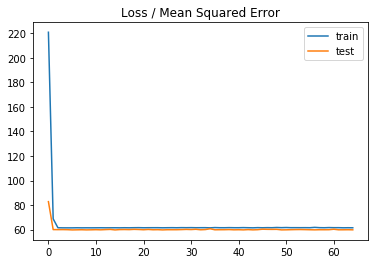

(61.12128048408322, 63.49852778737138)

In [31]:
model_training(model_4,X_train,X_test,Y_train,Y_test,plot=True )

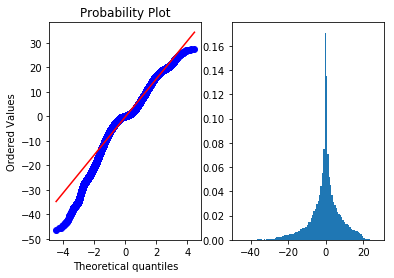

In [32]:
plot_stat(model_4,X_test,Y_test)

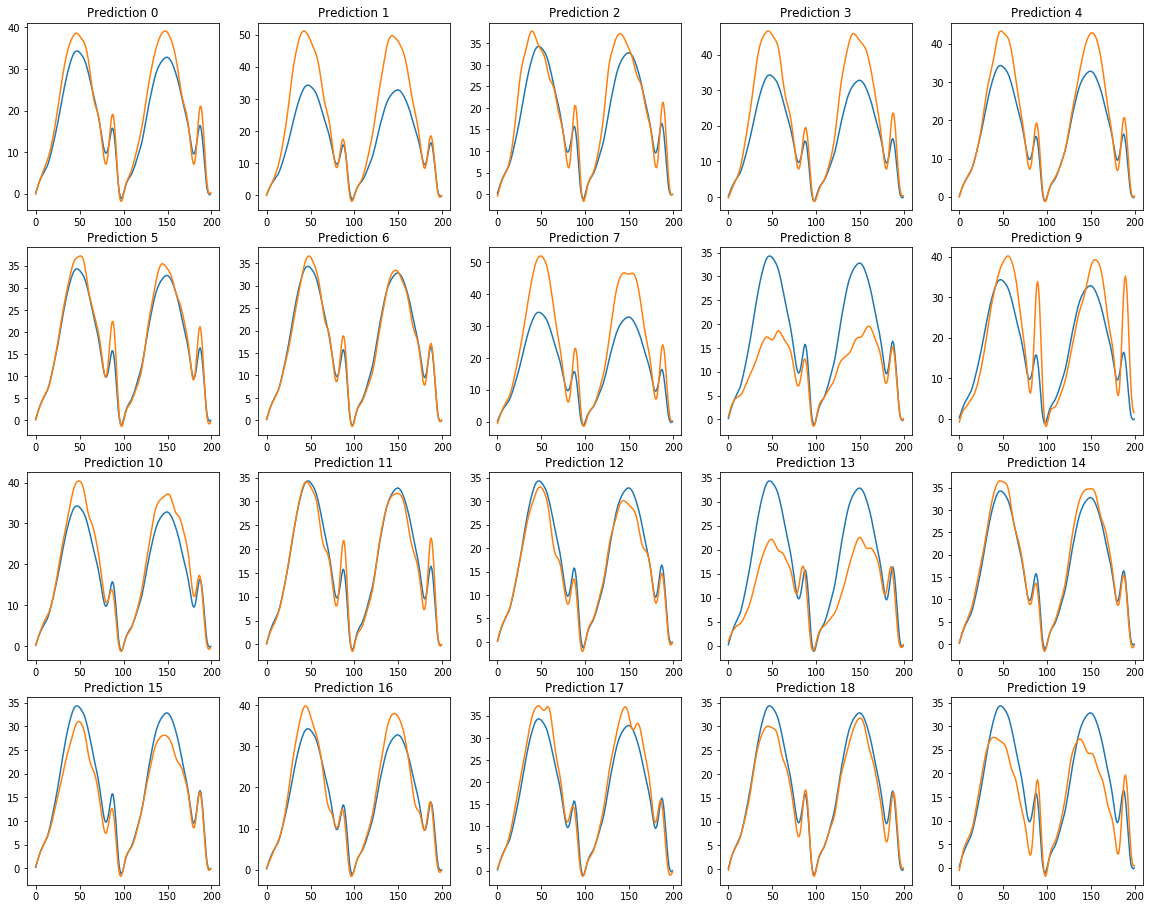

In [33]:
plot_prediction(model_4,X_test,Y_test)

###### Comments : We can see that this new configuration is not great because the MSE = 60 and the predictions looks terrible.

## We are now going to do cross validation for the base line model and the best model (2).

In [ ]:
k_fold = 4
train_mse_1,test_mse_1 = cross_validation(build_model_base_line, CP,k_fold)
print(f"Cross validation results : MSE train = {train_mse_1} | MSE test = {test_mse_1}")

In [174]:
k_fold = 4
train_mse,test_mse = cross_validation(build_model_2, CP,k_fold)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_19 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_20 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 200)               40200     
Total params: 120,600
Trainable params: 120,600
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00371: early stopping
Model: "sequential_33"
_________________________________________________________

# Now we are going to try to rescale the input in [0,1]

In [36]:
# Scaling the data
def scale( X,min_ , max_ ):
    return (X - min_)/(max_-min_) 

min_ = -90
max_ = 90 
num_train    = int(0.8*N_EXP)
X_train_insc = scale(CP[:num_train,0,:],min_ , max_ )
X_test_insc  = scale(CP[num_train:,0, :],min_ , max_ )
Y_train_insc = CP[:num_train,1,:]
Y_test_insc  = CP[num_train:,1,:]

## Base Line model
We first start by creating a base-line model in order to have a reference.

In [37]:
def build_model_baseline(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,)))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [38]:
model_rs_bs = build_model_baseline()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 200)               40200     
Total params: 40,200
Trainable params: 40,200
Non-trainable params: 0
_________________________________________________________________
None


MSE Train: 1.129 | MSE Test: 1.174


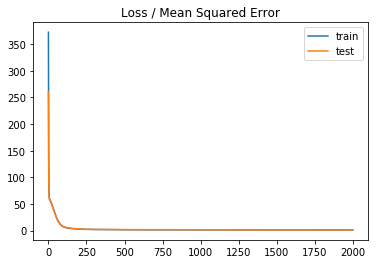

(1.1290016104535359, 1.17426551842108)

In [39]:
model_training(model_rs_bs,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

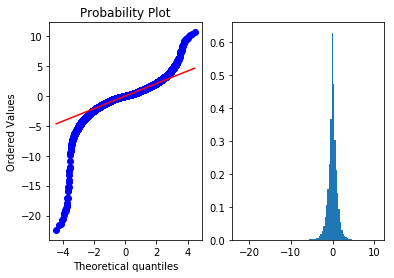

In [40]:
plot_stat(model_rs_bs,X_test_insc,Y_test_insc)

###### Comments : Rescaling the input produce a huge improvement

## Then let's apply the rescale to Model 1

In [41]:
def build_model_rs_1(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(200 ,input_shape=(200,) , activation = 'sigmoid' ))
    model.add(Dense(200 ))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [42]:
model_rs_1 = build_model_rs_1()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_17 (Dense)             (None, 200)               40200     
Total params: 80,400
Trainable params: 80,400
Non-trainable params: 0
_________________________________________________________________
None


Epoch 01300: early stopping
MSE Train: 0.650 | MSE Test: 0.752


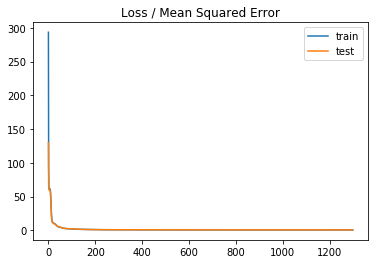

(0.6503221151305408, 0.7521137999325264)

In [43]:
model_training(model_rs_1,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

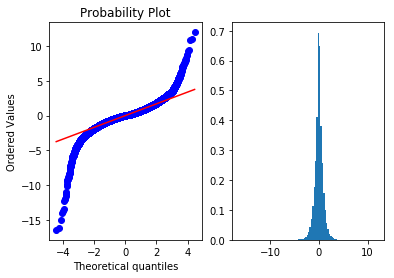

In [44]:
plot_stat(model_rs_1,X_test_insc,Y_test_insc)

###### Comments : Again this configuration with rescaling improve the MSE. However the QQplot is not amazing

## Then let's apply the rescale to Model 2

In [45]:
def build_model_rs_2(summary = True):
    
   #architecture
    model = Sequential()
    model.add(Dense(350 ,input_shape=(200,) , activation = 'sigmoid'))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [46]:
model_rs_2 = build_model_rs_2()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_19 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00809: early stopping
MSE Train: 0.684 | MSE Test: 0.790


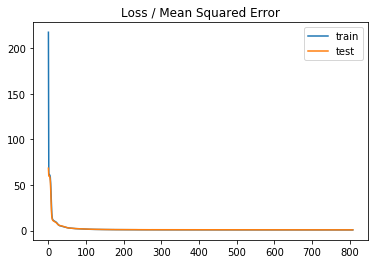

(0.6839671591433083, 0.7904590618319628)

In [47]:
model_training(model_rs_2,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

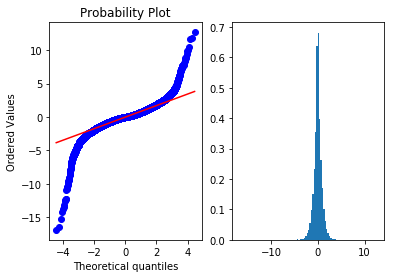

In [48]:
plot_stat(model_rs_2,X_test_insc,Y_test_insc)

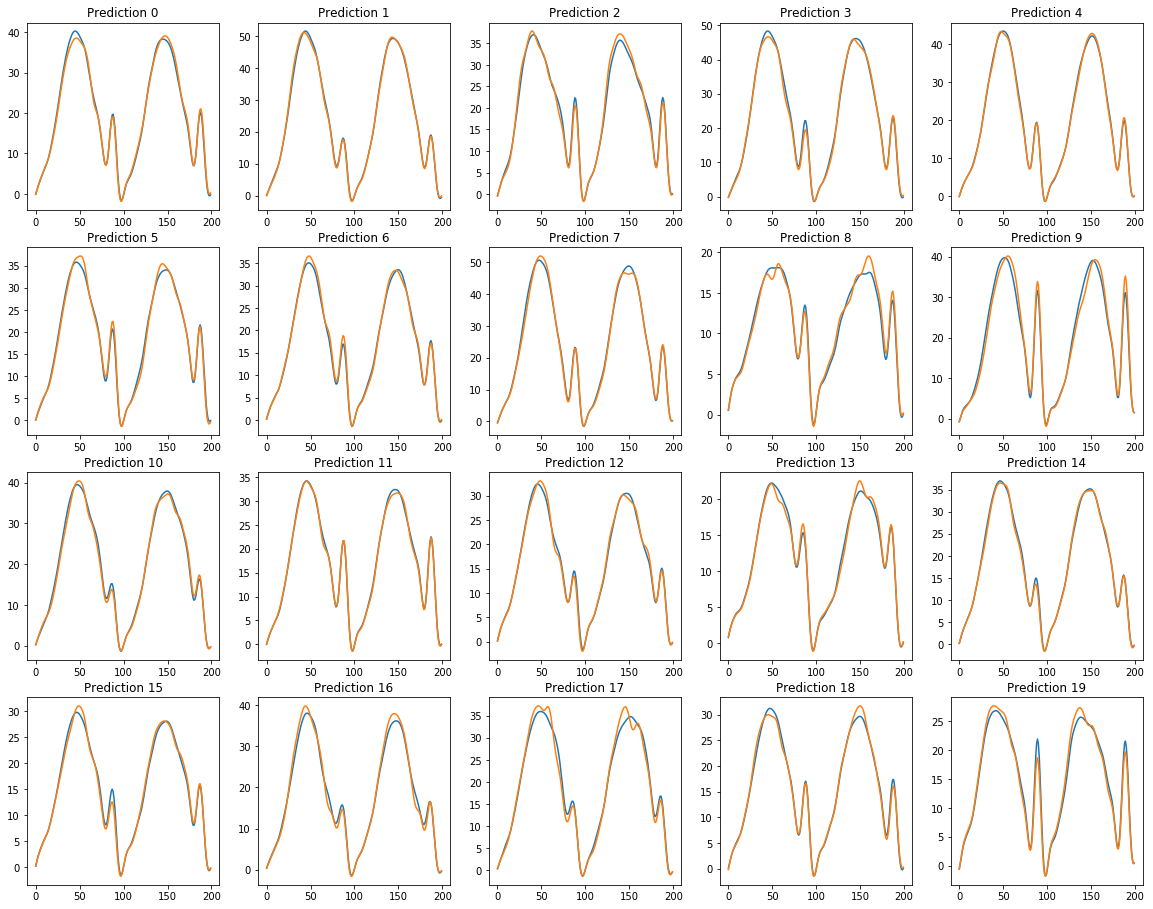

In [49]:
plot_prediction(model_rs_2 , X_test_insc , Y_test_insc)

###### Comments : The model with rescaling is not as great as the model1

## Then let's apply the rescale to Model 3

In [50]:
def build_model_rs_3(summary= True):
    
   #architecture
    model = Sequential()
    model.add(Dense(350 ,input_shape=(200,) , activation = 'sigmoid'))
    model.add(Dense(350, activation ='sigmoid'))
    model.add(Dense(200))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [51]:
model_rs_3 = build_model_rs_3()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_21 (Dense)             (None, 350)               122850    
_________________________________________________________________
dense_22 (Dense)             (None, 200)               70200     
Total params: 263,400
Trainable params: 263,400
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00548: early stopping
MSE Train: 0.637 | MSE Test: 0.822


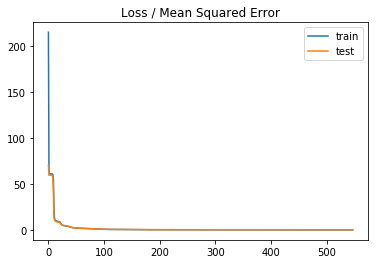

(0.6373639414950115, 0.8222725158784447)

In [52]:
model_training(model_rs_3,X_train_insc , X_test_insc , Y_train_insc , Y_test_insc , 50,plot = True)

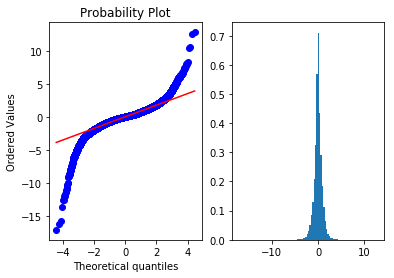

In [53]:
plot_stat(model_rs_3,X_test_insc,Y_test_insc)

### Cross validation on the base line model and the best model (2)

In [ ]:
k_fold = 4
patience_= 50
train_mse,test_mse = cross_validation_rs(build_model_baseline,CP,k_fold,50)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

 the test mse is : 1.178036319235476


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_84 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00827: early stopping
Train: 0.701, Test: 0.702


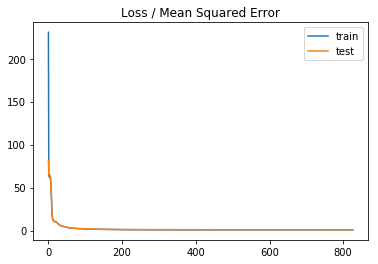

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_86 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00931: early stopping
Train: 0.690, Test: 0.743


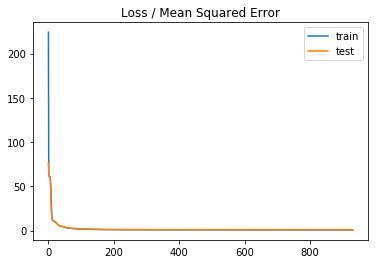

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_88 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00708: early stopping
Train: 0.703, Test: 0.785


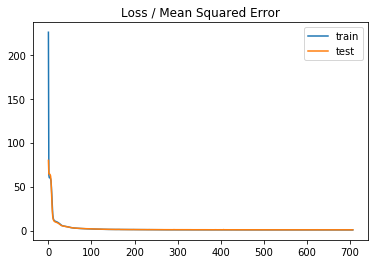

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 350)               70350     
_________________________________________________________________
dense_90 (Dense)             (None, 200)               70200     
Total params: 140,550
Trainable params: 140,550
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00679: early stopping
Train: 0.701, Test: 0.795


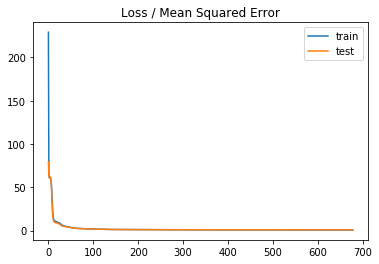

In [91]:
k_fold = 4
patience_=50
train_mse_1 , test_mse_1 = cross_validation_rs(build_model_rs_2,CP,k_fold,50)
print(f"Cross validation results : MSE train = {train_mse_1} | MSE test = {test_mse_1}")

## we obtain a better result by rescaling the input !

# Conclusion :
### Best model = build_model_rs_2 with a MSE = 0.756